In [4]:
import numpy as np

import MDAnalysis as mda
from MDAnalysis.analysis.distances import dist
from MDAnalysis.analysis.rdf import *
from MDAnalysis.coordinates.memory import MemoryReader
from MDAnalysis.analysis.base import AnalysisFromFunction
from MDAnalysis.transformations import *

import matplotlib.pyplot as plt

import os,re

import dask
import dask.array as da

import nglview as nv

import pickle

from membrane_curvature.base import MembraneCurvature

/home/ac127777/anaconda3/envs/mdanalysis-dev/lib/python3.8/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


MDAnalysis  : INFO     MDAnalysis 2.4.3 STARTED logging to 'MDAnalysis.log'
MDAnalysis  : INFO     MDAnalysis 2.4.3 STARTED logging to 'MDAnalysis.log'
MDAnalysis  : INFO     MDAnalysis 2.4.3 STARTED logging to 'MDAnalysis.log'


### MembraneCurvature works only with rectangular systems. If yours is triclinic or hexagonal instead, transform the box first. The following works for gromacs simulations.

## Change the box from triclinic to rectangular

In [ ]:
os.system('echo 0 | gmx_mpi trjconv -f traj.xtc -pbc mol -s topol.tpr -o traj_pbc_nobox.xtc') # echo 0 selects the entire system

In [3]:
utest=mda.Universe('topol.tpr','traj_pbc_nobox.xtc')

In [4]:
# vectorized only works for mda >= 2.7.0

In [ ]:
# older versions need this:

In [6]:
def change_box(ts):
    dims = ts.dimensions
    dims[1] = ts.triclinic_dimensions[1][1]
    ts.dimensions = dims
    return ts

In [7]:
def change_vecs(ts):
    vecs = ts.triclinic_dimensions
    vecs[1][0] = 0.
    ts.triclinic_dimensions = vecs
    return ts

In [8]:
workflow = [change_vecs, change_box]

In [9]:
utest.trajectory.add_transformations(*workflow)

In [10]:
with mda.Writer('traj_pbc_tric2rect.xtc', utest.atoms.n_atoms) as W:
    for ts in utest.trajectory:
        W.write(utest.atoms)

Center the protein in the box

In [ ]:
os.system('echo 1 0 | gmx_mpi trjconv -f traj_pbc_tric2rect.xtc -s topol.tpr -center -pbc mol -ur rect -o traj_pbc_tric2rect-c.xtc') # group 1 is the protein, group 0 the entire system

### membrane curvature

#### the leaflets have to be separated first and flipping lipids skipped #### 

In [1]:
# the following code was initially written to analyze molecules inside a membrane in protein vincinity and is used here as preprocessing tool

In [7]:
########################### po4 & water analysis ###################################

In [5]:
def extract_coords_traj(atomselection):
    coords = da.from_array(AnalysisFromFunction(lambda ag: ag.positions.copy(), atomselection.atoms).run().results['timeseries'])
    return coords   

In [6]:
def calc_distance_1d(xyz_index, frame, center_of_geom):

    distance = frame[:,xyz_index] - center_of_geom #create vectors for x,y,z
    return distance

In [7]:
def create_vectormask(coordframe_protein, coordframe_mol):

    xyz_index = 0
    while xyz_index < 3:
        center_of_geom = da.sum(coordframe_protein[:,xyz_index] / coordframe_protein[:,xyz_index].size) # center of geometry of lower beta hairpins
        if xyz_index == 0:
            xdist = calc_distance_1d(xyz_index, coordframe_mol, center_of_geom) # vectors h2o/po4 -> cog for x coord
        elif xyz_index == 1:
            ydist = calc_distance_1d(xyz_index, coordframe_mol, center_of_geom)
        elif xyz_index == 2:
            zdist = calc_distance_1d(xyz_index, coordframe_mol, center_of_geom)
        xyz_index += 1

    vecmask = da.vstack((xdist, ydist, zdist)) 
    return vecmask

In [8]:
class pore_analyzer:
    
    def __init__(self):
        
        self.trajectory_list = []
        self.topology_list = []
         
        # atom groups storage dict
        self.ag_storage = {"h2o":{'selection_str':'resname SOL and name OW',
                                     'ag':[],
                                 'coords':[],
                                 'resnums':[]},
                          "po4":{'selection_str':'not (resname SOL or resname NA or resname CL) and not protein and name OP*',
                                     'ag':[],
                                 'coords':[],
                                'resnums':[]},
                          "lipids":{'selection_str':'not (resname SOL or resname NA or resname CL) and not protein',
                                         'ag':[],
                                    'coords':[]},
                          "protein":{'selection_str':'protein and (resid 86-114 or resid 174-203)',# gasdermin-D, for gasdermin-A3 use resid 83-109 or resid 167-195
                                         'ag':[],
                                     'coords':[]}
                          }

        # lists to collect avgs in defects (or the exact numbers in the 1-frame case)
        self.in_defect_avg = {'h2o':[],
                              'po4':[]}
        
    def get_atom_groups_coords(self, sourcedata):
        
        u = mda.Universe(*sourcedata)

        for atomgroup in self.ag_storage:
            self.ag_storage[atomgroup]['ag'] = u.select_atoms(self.ag_storage[atomgroup]['selection_str'])
            if len(sourcedata) > 1:
                self.ag_storage[atomgroup]['coords'] = extract_coords_traj(self.ag_storage[atomgroup]['ag'])
            else:
                self.ag_storage[atomgroup]['coords'] = da.from_array(self.ag_storage[atomgroup]['ag'].positions.copy())
            
                
    def calc_membrane_dimensions(self, lipid_z_coords, phosphate_z_coords):    
        
        self.membrane_middle = da.mean(lipid_z_coords)
        self.membrane_zmax = da.mean(phosphate_z_coords[(phosphate_z_coords > self.membrane_middle)]) + 2 # +/- 2 angström buffer for a little unevenness of membrane
        self.membrane_zmin = da.mean(phosphate_z_coords[(phosphate_z_coords < self.membrane_middle)]) - 2
                                     
    def filter_coords_traj(self, ag):
        
        self.z_mask = (self.vectormasks[ag][:,:,2] > -30) & (self.vectormasks[ag][:,:,2] < +30).compute() # filter for z coord in 30 A dist from center of geom
        self.radii = (self.vectormasks[ag][:,:,0]**2 + self.vectormasks[ag][:,:,1]**2).compute() # radial filter based on x and y coord (around 10 A radius)
        self.xy_mask = ((da.from_array(self.radii) < 10**2)).compute()
                                     
    def filter_coords_singleframe(self, ag):
    
        self.z_mask = (self.vectormasks[ag][:,2] > -30) & (self.vectormasks[ag][:,2] < +30).compute() # filter for z coord in 30 A dist from center of geom
        self.radii = (self.vectormasks[ag][:,0]**2 + self.vectormasks[ag][:,1]**2).compute() # radial filter based on x and y coord (around 10 A radius)
        self.xy_mask = ((da.from_array(self.radii) < 10**2)).compute()       
                                     
    def id_molecules_traj(self, atomgroup, ag, coords_in_membrane_mask):
        
        residue_numbers = (da.atleast_2d(atomgroup.resnums).T).compute()
        z_mask_resnums = da.hstack((residue_numbers, (self.z_mask.T).compute()))
        xy_mask_resnums = da.hstack((residue_numbers, (da.from_array(self.xy_mask).T).compute()))
        resnums_in_membr = da.hstack((residue_numbers, (coords_in_membrane_mask.T).compute()))
                                     
        # compare mask id resnums 
        xyz_resnums = da.add(xy_mask_resnums[:,1:], z_mask_resnums[:,1:])
        all_resnums = da.add(xyz_resnums, resnums_in_membr[:,1:])
	
        comp = (all_resnums == 3).compute() # only consider resnums that appear in all 3 filters
        id_resnums = da.hstack((residue_numbers, comp))
	
        no_of_defect_molecules = da.sum(id_resnums[:,1:], axis=0) # count for each frame
        traj_average = da.mean(no_of_defect_molecules)
        self.in_defect_avg[ag].append(traj_average)
                                     
        xyz_resnums = []
        all_resnums = []
                                     
        return no_of_defect_molecules
    
    def id_molecules_single(self, atomgroup, ag, coords_in_membrane_mask):
        
        residue_numbers = (atomgroup.resnums)
        z_mask_resnums = np.vstack((residue_numbers, (self.z_mask))).T
        xy_mask_resnums = np.vstack((residue_numbers, (self.xy_mask))).T
        resnums_in_membr = np.vstack((residue_numbers, (coords_in_membrane_mask))).T
                                     
        # compare mask id resnums 
        xyz_resnums = np.add(xy_mask_resnums, z_mask_resnums)  
        all_resnums = np.add(xyz_resnums, resnums_in_membr)
           
        comp = (all_resnums[:,1] == 3) # only consider resnums that appear in all 3 filters
        id_resnums = np.array(np.vstack((residue_numbers, comp)).T)
        
        no_of_defect_molecules = np.sum(comp) # count
        self.in_defect_avg[ag].append(no_of_defect_molecules) # in this case it's not an avg ;-)
        
        # find the resnums and store them
        self.id_resnums = []
        for resnum, found in enumerate(id_resnums[:,1]):
            if found != 0:
                self.id_resnums.append(id_resnums[:,0][resnum])
	                            
        xyz_resnums = []
        all_resnums = []
                                     
        return no_of_defect_molecules
    
    ###### backend #######
    
    def export_data_loop(self, ag_name, traj_number, traj, no_of_defect_molecules):

        data=np.stack((self.trajectory_list[:traj_number+1], self.in_defect_avg[ag_name]),axis=1)
        np.savetxt('no_of_'+str(ag_name)+'_avg_per_traj.txt', data, fmt=['%s', '%.5f'], delimiter=' ', newline='\n', header='traj '+str(ag_name)+'_in_defect')
                                     
    def export_final_data_single(self, ag, no_of_defect_molecules):

        np.savetxt('no_of_'+str(ag)+'_single.txt',no_of_defect_molecules,fmt='%s',delimiter=' ',newline='\n',header=str(ag)+'_in_defect')
                                     
    def export_final_data_pdb(self, ag, no_of_defect_molecules): 
        
        np.savetxt('resnums_'+str(ag)+'_in_def_'+str(self.pdbfile[:-4])+'.txt', self.ag_storage[ag]['resnums'], delimiter=' ', fmt='%i',newline='\n',header=str(no_of_defect_molecules)+' '+str(ag)+' in defect')                            
                                     
    ###### production ######

    def looprun(self):
        
        for traj_number, traj in enumerate(self.trajectory_list):
            
            if traj_number > 44:
            
                self.get_atom_groups_coords([self.topology_list[traj_number], traj])

                # find coords in pore 
                self.vectormasks = {'h2o':[],
                                    'po4':[]}
                self.coords_in_membrane_masks = {'h2o':[],
                                           'po4':[]}


                for frame_no, frame in enumerate(self.ag_storage['protein']['coords']):

                    # membrane dimensions
                    lipid_z_coords = self.ag_storage['lipids']['coords'][:,:,2][frame_no]
                    phosphate_z_coords = self.ag_storage['po4']['coords'][:,:,2][frame_no]

                    self.calc_membrane_dimensions(lipid_z_coords,phosphate_z_coords)


                    for ag_n, ag in enumerate(['h2o', 'po4']):

                        vecmask = create_vectormask(frame, self.ag_storage[ag]['coords'][frame_no])

                        # find h2o/po4 in membrane region adaptive to conditions in each frame    
                        ag_coords_in_membrane_mask = ((self.ag_storage[ag]['coords'][:,:,2][frame_no] < self.membrane_zmax) & (self.ag_storage[ag]['coords'][:,:,2][frame_no] > self.membrane_zmin)).compute()    

                        if frame_no == 0:
                            self.vectormasks[ag] = (vecmask.T).compute()
                            self.coords_in_membrane_masks[ag] = ag_coords_in_membrane_mask

                        elif frame_no == 1:
                            self.vectormasks[ag] = da.stack((self.vectormasks[ag],(vecmask.T).compute()))
                            self.coords_in_membrane_masks[ag] = da.stack((self.coords_in_membrane_masks[ag], ag_coords_in_membrane_mask))

                        else: 
                            self.vectormasks[ag] = da.append(self.vectormasks[ag], (da.atleast_3d(vecmask).T).compute(), axis = 0)
                            self.coords_in_membrane_masks[ag] = da.append(self.coords_in_membrane_masks[ag], da.array([ag_coords_in_membrane_mask]), axis = 0)               

                for ag_n, ag in enumerate(['h2o', 'po4']):

                    self.filter_coords_traj(ag)

                    no_of_defect_molecules = self.id_molecules_traj(self.ag_storage[ag]['ag'], ag, self.coords_in_membrane_masks[ag])

                    self.export_data_loop(ag, traj_number, traj, no_of_defect_molecules)
                                     
                
            
    def singletrajrun(self, topology, trajectory):
                                     
        self.get_atom_groups_coords([topology, trajectory])
        
        # find coords in pore 
        self.vectormasks = {'h2o':[],
                            'po4':[]}
        self.coords_in_membrane_masks = {'h2o':[],
                                   'po4':[]}
                                     
        for frame_no, frame in enumerate(self.ag_storage['protein']['coords']):

            # membrane dimensions
            lipid_z_coords = self.ag_storage['lipids']['coords'][:,:,2][frame_no]
            phosphate_z_coords = self.ag_storage['po4']['coords'][:,:,2][frame_no]

            self.calc_membrane_dimensions(lipid_z_coords,phosphate_z_coords)

            for ag_n, ag in enumerate(['h2o', 'po4']):

                vecmask = create_vectormask(frame, self.ag_storage[ag]['coords'][frame_no])
                
                # find h2o/po4 in membrane region adaptive to conditions in each frame    
                ag_coords_in_membrane_mask = ((self.ag_storage[ag]['coords'][:,:,2][frame_no] < self.membrane_zmax) & (self.ag_storage[ag]['coords'][:,:,2][frame_no] > self.membrane_zmin)).compute()    

                if frame_no == 0:
                    self.vectormasks[ag] = (vecmask.T).compute()
                    self.coords_in_membrane_masks[ag] = ag_coords_in_membrane_mask

                elif frame_no == 1:
                    self.vectormasks[ag] = da.stack((self.vectormasks[ag],(vecmask.T).compute()))
                    self.coords_in_membrane_masks[ag] = da.stack((self.coords_in_membrane_masks[ag], ag_coords_in_membrane_mask))

                else: 
                    self.vectormasks[ag] = da.append(self.vectormasks[ag], (da.atleast_3d(vecmask).T).compute(), axis = 0)
                    self.coords_in_membrane_masks[ag] = da.append(self.coords_in_membrane_masks[ag], da.array([ag_coords_in_membrane_mask]), axis = 0)             

        for ag_n, ag in enumerate(['h2o', 'po4']):
            
            self.filter_coords_traj(ag)

            no_of_defect_molecules = self.id_molecules_traj(self.ag_storage[ag]['ag'], ag, self.coords_in_membrane_masks[ag])

            self.export_final_data_single(ag, no_of_defect_molecules)
                                     
                                     
            
    def singleframerun(self, pdbfile:str):
        
        self.get_atom_groups_coords([pdbfile])
        
        # membrane dims
        lipid_z_coords = self.ag_storage['lipids']['coords'][:,2]
        phosphate_z_coords = self.ag_storage['po4']['coords'][:,2]

        self.calc_membrane_dimensions(lipid_z_coords,phosphate_z_coords)

        # find coords in pore
        self.vectormasks = {'h2o':[],
                            'po4':[]}  
        self.coords_in_membrane_masks = {'h2o':[],
                                   'po4':[]}
        
        for ag_n, ag in enumerate(['h2o', 'po4']):
            
            vecmask = create_vectormask(self.ag_storage['protein']['coords'], self.ag_storage[ag]['coords'])
                                                                                                                                
           # find h2o/po4 in membrane region adaptive to conditions in each frame    
            ag_coords_in_membrane_mask = ((self.ag_storage[ag]['coords'][:,2]<self.membrane_zmax) & (self.ag_storage[ag]['coords'][:,2] > self.membrane_zmin)).compute()  
            self.coords_in_membrane_masks[ag] = ag_coords_in_membrane_mask
        
            self.vectormasks[ag] = vecmask.T        

            self.filter_coords_singleframe(ag)

            no_of_defect_molecules = np.array(self.id_molecules_single(self.ag_storage[ag]['ag'], ag, self.coords_in_membrane_masks[ag]))
            print(no_of_defect_molecules)
            self.ag_storage[ag]['resnums'] = self.id_resnums
            self.export_final_data_pdb(ag, no_of_defect_molecules)

single frame

In [9]:
u0 = mda.Universe('frame24131_a3_hdgrps_only_noprot.pdb')

In [10]:
pdbfile = 'frame24131_a3_hdgrps_only_noprot.pdb'

Pore_analyzer = pore_analyzer()

In [11]:
Pore_analyzer.ag_storage['po4']['selection_str'] = 'not (resname SOL or resname NA or resname CL) and not protein and (name P or name P*)'

In [12]:
Pore_analyzer.get_atom_groups_coords([pdbfile])

In [13]:
Pore_analyzer.headgroups_leaflets_masks = {'upper':[],
                                           'lower':[]}

In [14]:
def id_molecules_1frame_leaflets(atomgroup, coords_mask):
    
    residue_numbers = da.array(atomgroup.resnums)
    
    resnums_per_frame = []
    no_of_resnums_per_frame = []
    
    resnums_in_frame = np.unique(residue_numbers[coords_mask])
    resnums_per_frame.append(np.array(resnums_in_frame))
    no_of_resnums_in_frame = len(np.array(resnums_in_frame))
    no_of_resnums_per_frame.append(no_of_resnums_in_frame)
    
    return resnums_per_frame, no_of_resnums_per_frame

In [15]:
lipid_z_coords = Pore_analyzer.ag_storage['lipids']['coords'][:,2]
phos_z_coords = Pore_analyzer.ag_storage['po4']['coords'][:,2]
Pore_analyzer.calc_membrane_dimensions(lipid_z_coords,phos_z_coords)

for leaflet in Pore_analyzer.headgroups_leaflets_masks.keys():

    # find headgroups in leaflets
    if leaflet == 'upper':
        leaflet_mask = (phos_z_coords > Pore_analyzer.membrane_middle).compute() 
    elif leaflet == 'lower':
        leaflet_mask = (phos_z_coords < Pore_analyzer.membrane_middle).compute()

    Pore_analyzer.headgroups_leaflets_masks[leaflet] = leaflet_mask

In [16]:
no_of_hdgrps_in_lflt = {'upper':[],
                        'lower':[]}
id_resnums = {'upper':[],
              'lower':[]}
normal_frames = {'upper':[],
                 'lower':[]}
no_of_resnums_in_frame = {'upper':[],
                          'lower':[]}

In [17]:
for leaflet in Pore_analyzer.headgroups_leaflets_masks.keys():
    
    id_resnums[leaflet], no_of_resnums_in_frame[leaflet] = id_molecules_1frame_leaflets(Pore_analyzer.ag_storage['po4']['ag'], Pore_analyzer.headgroups_leaflets_masks[leaflet])

In [18]:
final_resnums_upper = np.unique(id_resnums['upper'][0])

In [19]:
final_resnums_lower = np.unique(id_resnums['lower'][0])

In [20]:
def sort_atoms_into_leaflets(final_resnums, universe):
    
    atomlist = []
    
    for resnum in final_resnums:
        ag = u0.select_atoms('resnum '+str(resnum)+' and (name P or name P*)')
        
        for atomindex in ag.ix:
            atomlist.append(atomindex)

    atoms_in_leaflet = u0.atoms[atomlist]
    
    return atoms_in_leaflet

In [21]:
upper_leaflet_1frame = sort_atoms_into_leaflets(final_resnums_upper, u0)
lower_leaflet_1frame = sort_atoms_into_leaflets(final_resnums_lower, u0)

In [22]:
# find x and y max dimensions to configure MembraneCurvature accordingly - 1 frame

In [23]:
np.max(np.array(Pore_analyzer.ag_storage['po4']['coords'])[:,0]) # x

138.24

In [24]:
np.min(np.array(Pore_analyzer.ag_storage['po4']['coords'])[:,0]) # x

-2.89

In [25]:
np.max(np.array(Pore_analyzer.ag_storage['po4']['coords'])[:,1]) # y

118.41

In [26]:
np.min(np.array(Pore_analyzer.ag_storage['po4']['coords'])[:,1]) # y

0.2

In [27]:
# find bins that work - trial and error lol

In [28]:
x_bins = 8

In [29]:
y_bins = 8

In [30]:
max_x = 130
min_x = 0

In [31]:
max_y = 110
min_y = 0

In [32]:
x_factor = x_bins / max_x

In [33]:
y_factor = y_bins / max_y

In [34]:
x_coords, y_coords, z_coords = upper_leaflet_1frame.positions.T

cell_x_floor = np.floor(x_coords * x_factor).astype(int)
cell_y_floor = np.floor(y_coords * y_factor).astype(int)

check visually if your grid fits your data points. All your actual bins (bins btwn min_x and max_x as well as min_y and max_y) have to atleast contain 1 data point! If this is not the case, retry with different bins and dimension settings.

In [35]:
####### plot settings #####
plt.rcParams["figure.figsize"] = (16.5,11)
plt.rcParams["font.size"] = 24

Text(0.5, 1.0, 'upper leaflet')

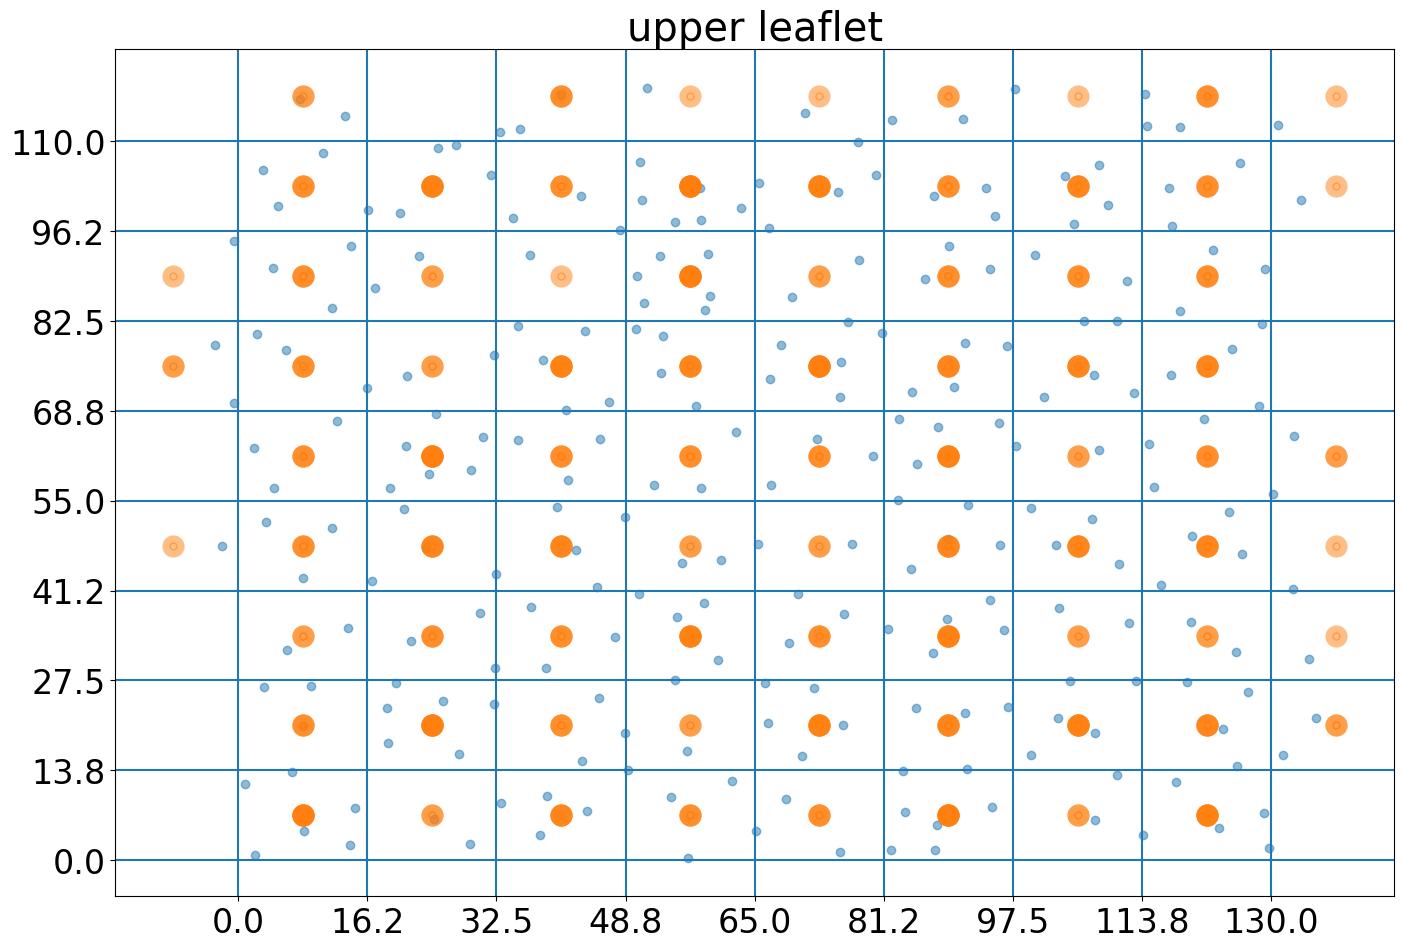

In [40]:
plt.scatter(upper_leaflet_1frame.positions[:,0],upper_leaflet_1frame.positions[:,1], alpha=0.5)
plt.scatter(cell_x_floor*(max_x/x_bins)+max_x/(x_bins*2),cell_y_floor*(max_y/y_bins)+max_y/(y_bins*2), alpha=0.5,linewidths=10)
for i in np.linspace(min_y,max_y,y_bins+1):
    plt.axhline(y=i)
for i in np.linspace(min_x,max_x,x_bins+1):
    plt.axvline(x=i)
plt.xticks(np.linspace(min_x, max_x, x_bins+1))
plt.yticks(np.linspace(min_y, max_y, y_bins+1))
plt.title('upper leaflet')

In [41]:
x_coords, y_coords, z_coords = lower_leaflet_1frame.positions.T

cell_x_floor = np.floor(x_coords * x_factor).astype(int)
cell_y_floor = np.floor(y_coords * y_factor).astype(int)

Text(0.5, 1.0, 'lower leaflet')

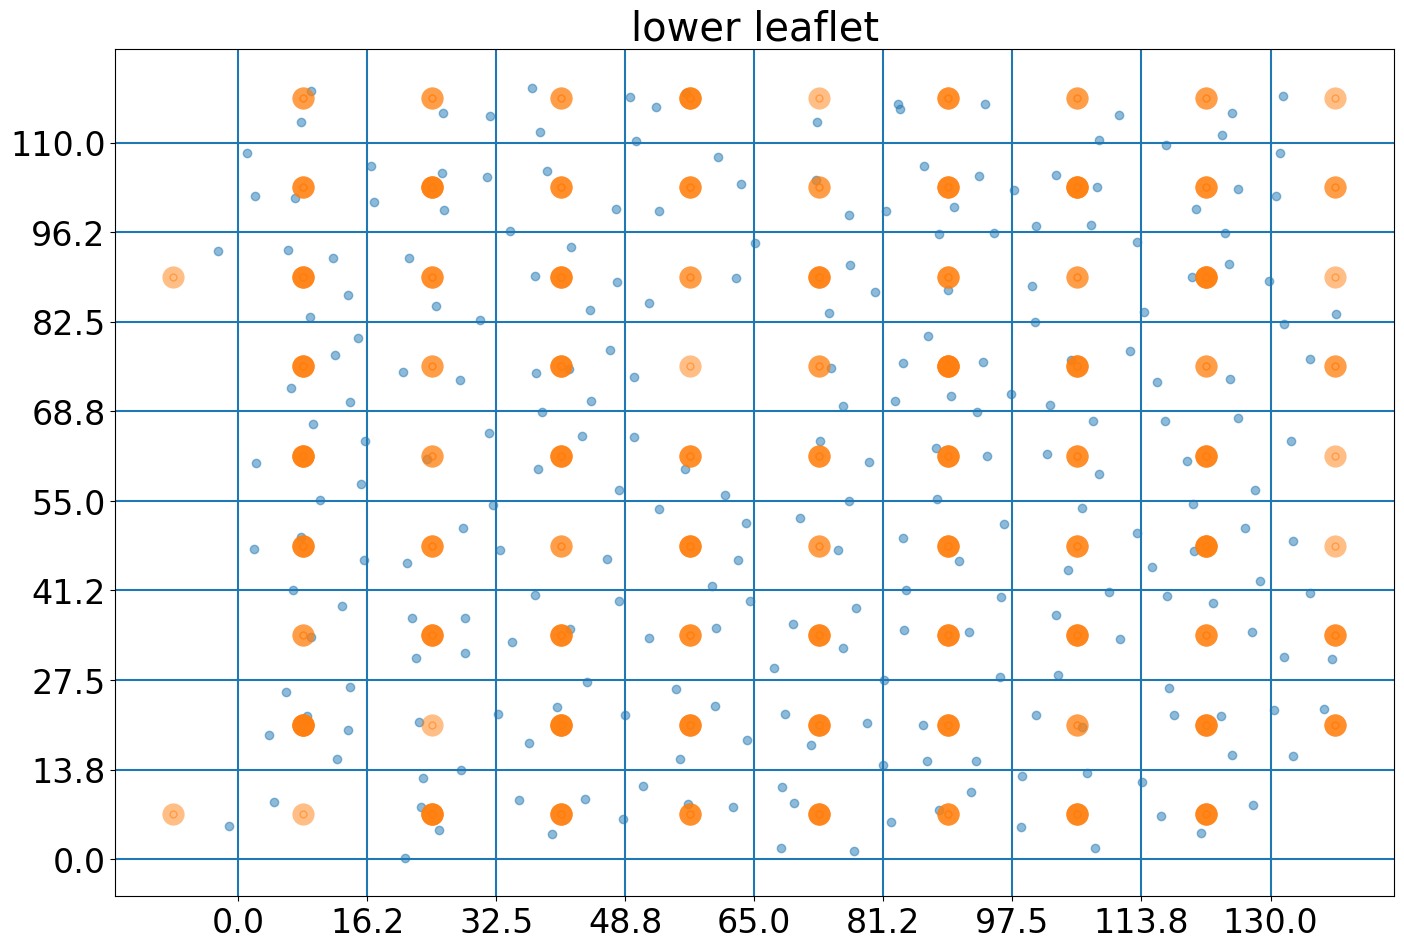

In [44]:
plt.scatter(lower_leaflet_1frame.positions[:,0],lower_leaflet_1frame.positions[:,1], alpha=0.5)
plt.scatter(cell_x_floor*(max_x/x_bins)+max_x/(x_bins*2),cell_y_floor*(max_y/y_bins)+max_y/(y_bins*2), alpha=0.5,linewidths=10)
for i in np.linspace(min_y,max_y,y_bins+1):
    plt.axhline(y=i)
for i in np.linspace(min_x,max_x,x_bins+1):
    plt.axvline(x=i)
plt.xticks(np.linspace(min_x, max_x, x_bins+1))
plt.yticks(np.linspace(min_y, max_y, y_bins+1))
plt.title('lower leaflet')

if you found your working settings, you can actually run MembraneCurvature! 

In [45]:
curvature_upper_leaflet = MembraneCurvature(upper_leaflet_1frame, x_range=(min_x,max_x), y_range=(min_y,max_y),n_x_bins=x_bins, n_y_bins=y_bins,
                                            wrap=False).run() # wrap=False is valid if you did pbc mol and center e.g. in gromacs beforehand

/home/ac127777/anaconda3/envs/mdanalysis-dev/lib/python3.8/site-packages/membrane_curvature-0+unknown-py3.8.egg/membrane_curvature/base.py:150: UserWarning: Grid range in x does not cover entire dimensions of simulation box.
 Minimum dimensions must be equal to simulation box.
MDAnalysis.MDAKit.membrane_curvature: WARNING  Grid range in x does not cover entire dimensions of simulation box.
 Minimum dimensions must be equal to simulation box.
MDAnalysis.MDAKit.membrane_curvature: WARNING  Grid range in x does not cover entire dimensions of simulation box.
 Minimum dimensions must be equal to simulation box.
/home/ac127777/anaconda3/envs/mdanalysis-dev/lib/python3.8/site-packages/membrane_curvature-0+unknown-py3.8.egg/membrane_curvature/base.py:150: UserWarning: Grid range in y does not cover entire dimensions of simulation box.
 Minimum dimensions must be equal to simulation box.
MDAnalysis.MDAKit.membrane_curvature: WARNING  Grid range in y does not cover entire dimensions of simulatio

In [46]:
# extract surface
surface_upper_leaflet = curvature_upper_leaflet.results.average_z_surface

# extract curvature
mean_upper_leaflet = curvature_upper_leaflet.results.average_mean

# extract Gaussian curvature
gaussian_upper_leaflet = curvature_upper_leaflet.results.average_gaussian

In [47]:
curvature_lower_leaflet = MembraneCurvature(lower_leaflet_1frame, x_range=(min_x,max_x), y_range=(min_y,max_y),n_x_bins=x_bins, n_y_bins=y_bins,
                                            wrap=False).run()

MDAnalysis.MDAKit.membrane_curvature: WARNING  Grid range in x does not cover entire dimensions of simulation box.
 Minimum dimensions must be equal to simulation box.
MDAnalysis.MDAKit.membrane_curvature: WARNING  Grid range in x does not cover entire dimensions of simulation box.
 Minimum dimensions must be equal to simulation box.
MDAnalysis.MDAKit.membrane_curvature: WARNING  Grid range in y does not cover entire dimensions of simulation box.
 Minimum dimensions must be equal to simulation box.
MDAnalysis.MDAKit.membrane_curvature: WARNING  Grid range in y does not cover entire dimensions of simulation box.
 Minimum dimensions must be equal to simulation box.
MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == False` may result in inaccurate calculation of membrane curvature. Surfaces will be derived from a reduced number of atoms. 
  Ignore this warning if your trajectory has  rotational/translational fit rotations! 
MDAnalysis.MDAKit.membrane_curvature: WARNING   `wrap == Fa

In [48]:
# extract surface
surface_lower_leaflet = curvature_lower_leaflet.results.average_z_surface

# extract curvature
mean_lower_leaflet = curvature_lower_leaflet.results.average_mean

# extract Gaussian curvature
gaussian_lower_leaflet = curvature_lower_leaflet.results.average_gaussian

In [49]:
####### plot settings #####
plt.rcParams["figure.figsize"] = (16.5,11)
plt.rcParams["font.size"] = 24

/tmp/ipykernel_1255945/2396025198.py:8: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im0, fraction=0.05, pad=-2.38)


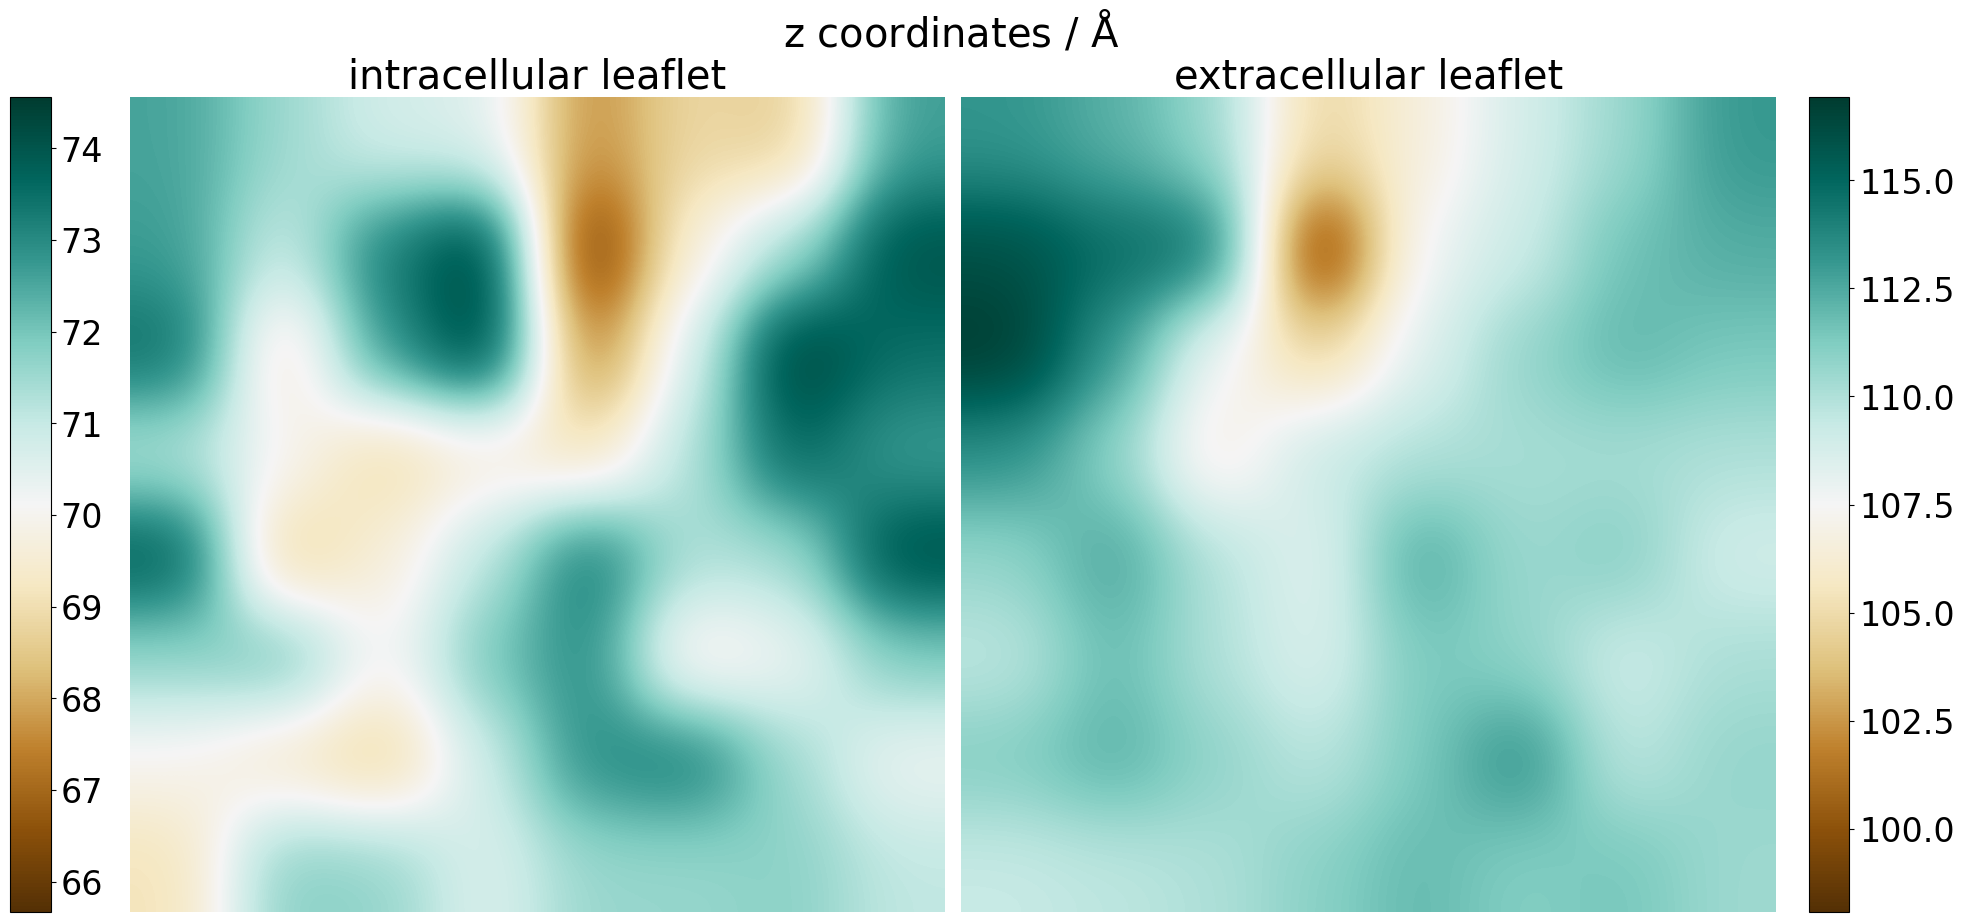

In [50]:
fig, ax = plt.subplots(ncols=2, constrained_layout=True) # watch out for the constrained layout arg, it changed in newer versions of matplotlib!
im0 = ax[0].imshow(surface_lower_leaflet.T, origin='lower', interpolation='gaussian', cmap='BrBG')
ax[0].axis('off')
ax[0].set_title('intracellular leaflet')
im1 = ax[1].imshow(surface_upper_leaflet.T, origin='lower', interpolation='gaussian', cmap='BrBG')
ax[1].axis('off')
ax[1].set_title('extracellular leaflet')
fig.colorbar(im0, fraction=0.05, pad=-2.38) # adjust the padding to your likes
fig.colorbar(im1, fraction=0.05, pad=0.04)
fig.suptitle(r'z coordinates / $\mathrm{\AA}$', y=0.95) # adjust the title yloc to your likes
#plt.savefig('z_coords_surf.png', dpi=200, bbox_inches='tight')
plt.show()

/tmp/ipykernel_1255945/2780215474.py:8: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im0, fraction=0.05, pad=-2.39)


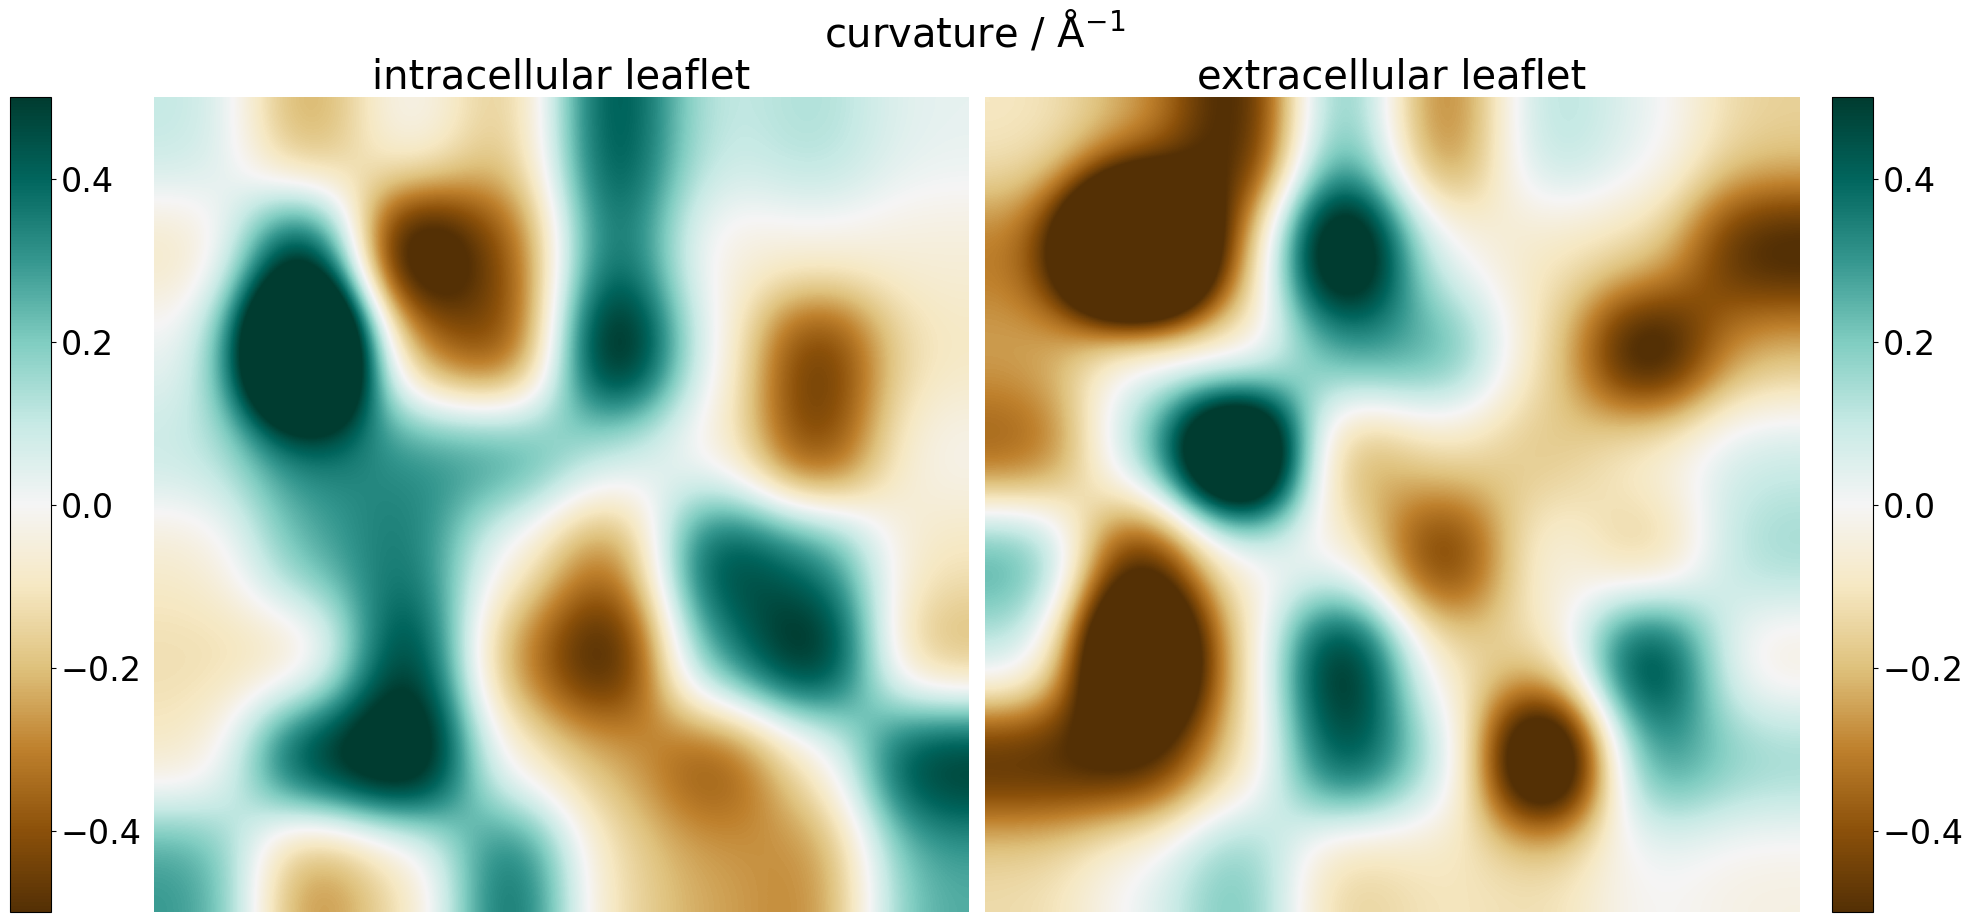

In [53]:
fig, ax = plt.subplots(ncols=2, constrained_layout=True)
im0 = ax[0].imshow(mean_lower_leaflet.T, origin='lower', interpolation='gaussian', cmap='BrBG', vmin=-0.5, vmax=0.5) # decide on a uniform scale using vmin and vmax
ax[0].axis('off')
ax[0].set_title('intracellular leaflet')
im1 = ax[1].imshow(mean_upper_leaflet.T, origin='lower', interpolation='gaussian', cmap='BrBG', vmin=-0.5, vmax=0.5)
ax[1].axis('off')
ax[1].set_title('extracellular leaflet')
fig.colorbar(im0, fraction=0.05, pad=-2.39)
fig.colorbar(im1, fraction=0.05, pad=0.04)
fig.suptitle(r'curvature / $\mathrm{\AA}^{-1}$', y=0.95)
#plt.savefig('curvature_a3_8_8_frame24131.png', dpi=200, bbox_inches='tight')
plt.show()

mean curvature is probably the best measure here

/tmp/ipykernel_1255945/2778686857.py:8: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im0, fraction=0.044, pad=-2.37)


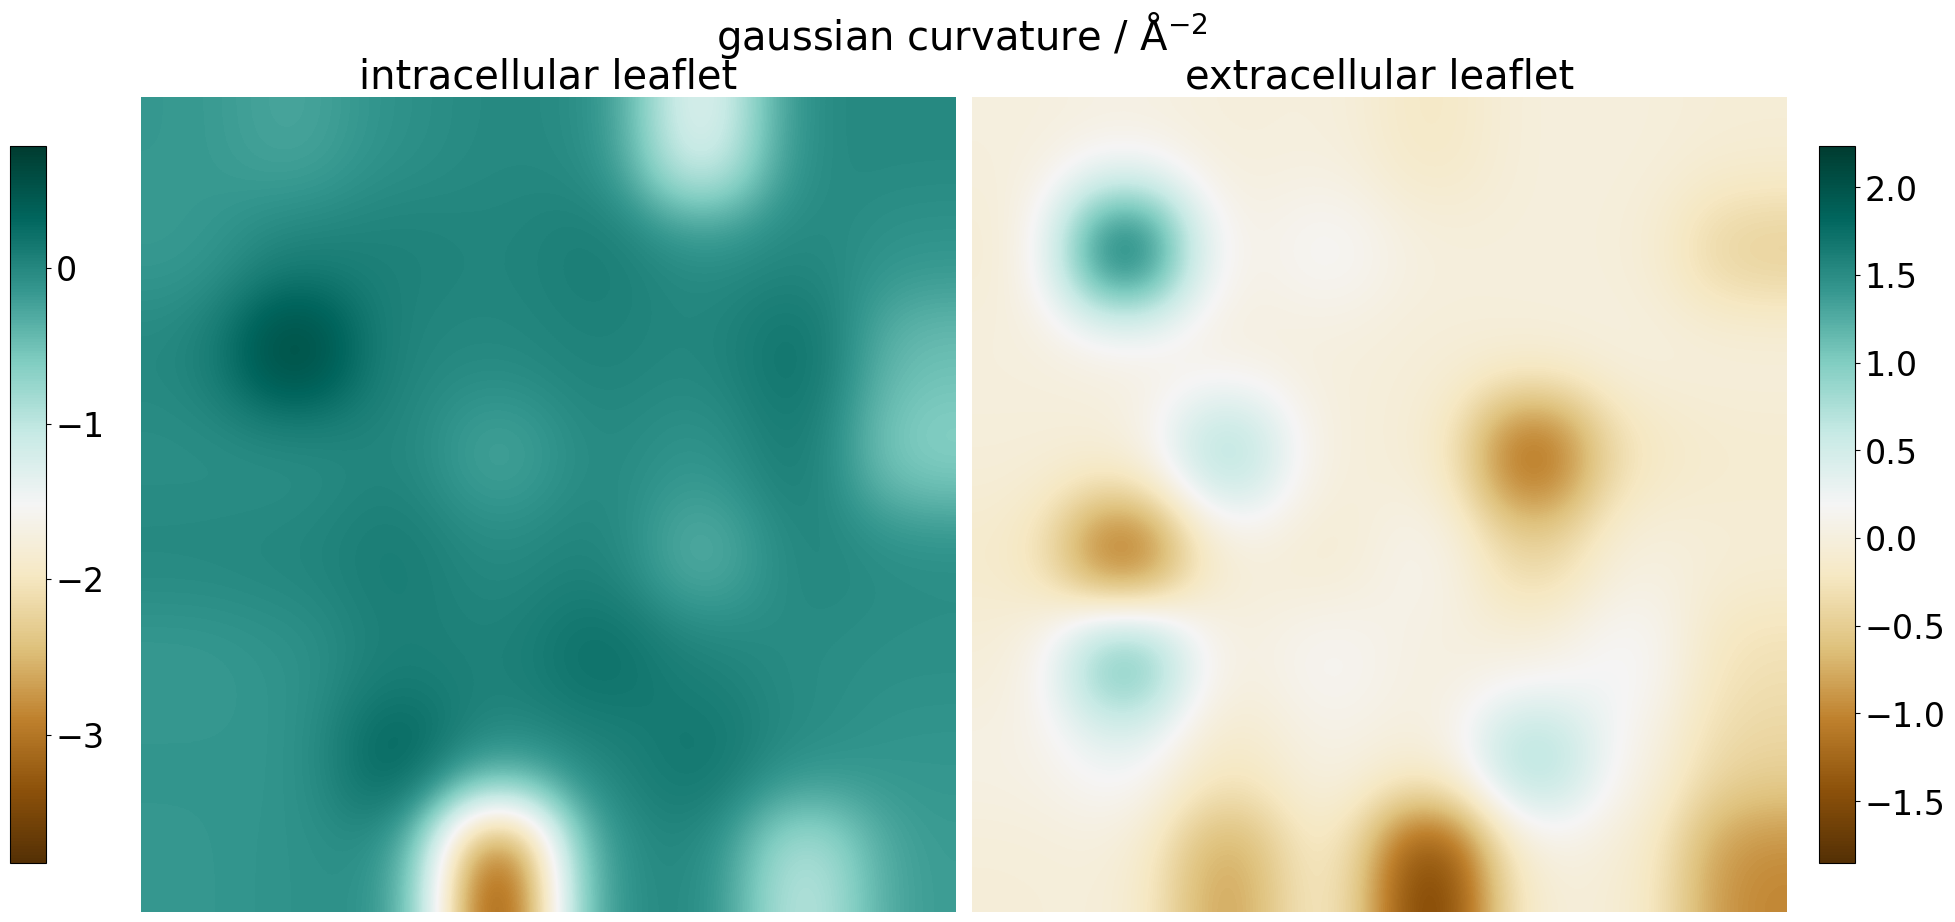

In [54]:
fig, ax = plt.subplots(ncols=2, constrained_layout=True)
im0 = ax[0].imshow(gaussian_lower_leaflet.T, origin='lower', interpolation='gaussian', cmap='BrBG')
ax[0].axis('off')
ax[0].set_title('intracellular leaflet')
im1 = ax[1].imshow(gaussian_upper_leaflet.T, origin='lower', interpolation='gaussian', cmap='BrBG')
ax[1].axis('off')
ax[1].set_title('extracellular leaflet')
fig.colorbar(im0, fraction=0.044, pad=-2.37)
fig.colorbar(im1, fraction=0.044, pad=0.04)
fig.suptitle(r'gaussian curvature / $\mathrm{\AA}^{-2}$', y=0.95)
#plt.savefig('gaussian_curvature.png', dpi=200, bbox_inches='tight')
plt.show()

trajectory

In [57]:
u0 = mda.Universe('topol.tpr', 'traj100_pbc_rect-c.xtc')

MDAnalysis.topology.TPRparser: INFO     Gromacs version   : b'VERSION 2018.6'
MDAnalysis.topology.TPRparser: INFO     Gromacs version   : b'VERSION 2018.6'
MDAnalysis.topology.TPRparser: INFO     tpx version       : 112
MDAnalysis.topology.TPRparser: INFO     tpx version       : 112
MDAnalysis.topology.TPRparser: INFO     tpx generation    : 26
MDAnalysis.topology.TPRparser: INFO     tpx generation    : 26
MDAnalysis.topology.TPRparser: INFO     tpx precision     : 4
MDAnalysis.topology.TPRparser: INFO     tpx precision     : 4
MDAnalysis.topology.TPRparser: INFO     tpx file_tag      : b'release'
MDAnalysis.topology.TPRparser: INFO     tpx file_tag      : b'release'
MDAnalysis.topology.TPRparser: INFO     tpx natoms        : 264760
MDAnalysis.topology.TPRparser: INFO     tpx natoms        : 264760
MDAnalysis.topology.TPRparser: INFO     tpx ngtc          : 2
MDAnalysis.topology.TPRparser: INFO     tpx ngtc          : 2
MDAnalysis.topology.TPRparser: INFO     tpx fep_state     : 0
MDAn

...5000 frames works, 50000 are too much (for my RAM)

In [58]:
top='topol.tpr'
traj='traj100_pbc_rect-c.xtc'

Pore_analyzer = pore_analyzer()

In [59]:
Pore_analyzer.ag_storage['po4']['selection_str'] = 'not (resname SOL or resname NA or resname CL) and not protein and (name P or name P*)'

In [60]:
Pore_analyzer.get_atom_groups_coords([top,traj])

MDAnalysis.topology.TPRparser: INFO     Gromacs version   : b'VERSION 2018.6'
MDAnalysis.topology.TPRparser: INFO     Gromacs version   : b'VERSION 2018.6'
MDAnalysis.topology.TPRparser: INFO     tpx version       : 112
MDAnalysis.topology.TPRparser: INFO     tpx version       : 112
MDAnalysis.topology.TPRparser: INFO     tpx generation    : 26
MDAnalysis.topology.TPRparser: INFO     tpx generation    : 26
MDAnalysis.topology.TPRparser: INFO     tpx precision     : 4
MDAnalysis.topology.TPRparser: INFO     tpx precision     : 4
MDAnalysis.topology.TPRparser: INFO     tpx file_tag      : b'release'
MDAnalysis.topology.TPRparser: INFO     tpx file_tag      : b'release'
MDAnalysis.topology.TPRparser: INFO     tpx natoms        : 264760
MDAnalysis.topology.TPRparser: INFO     tpx natoms        : 264760
MDAnalysis.topology.TPRparser: INFO     tpx ngtc          : 2
MDAnalysis.topology.TPRparser: INFO     tpx ngtc          : 2
MDAnalysis.topology.TPRparser: INFO     tpx fep_state     : 0
MDAn

In [61]:
Pore_analyzer.headgroups_leaflets_masks = {'upper':[],
                                           'lower':[]}

In [62]:
def id_molecules_traj_leaflets(atomgroup, coords_mask):
    
    residue_numbers = da.array(atomgroup.resnums)
    
    resnums_per_frame = []
    no_of_resnums_per_frame = []
    
    for frame in coords_mask:
        resnums_in_frame = np.unique(residue_numbers[frame])
        resnums_per_frame.append(np.array(resnums_in_frame))
        no_of_resnums_in_frame = len(np.array(resnums_in_frame))
        no_of_resnums_per_frame.append(no_of_resnums_in_frame)

    return resnums_per_frame, no_of_resnums_per_frame

In [63]:
def count_molecules_traj_leaflets(coords_mask):
    
    no_of_hdgrps_in_lflt = da.sum(coords_mask.astype(int), axis=1)
    
    avg = int(np.round(np.mean(no_of_hdgrps_in_lflt)))
    
    normal_frames = da.argwhere(no_of_hdgrps_in_lflt == avg)
    
    return np.array(no_of_hdgrps_in_lflt), np.array(normal_frames)

In [64]:
for frame_no, frame in enumerate(Pore_analyzer.ag_storage['po4']['coords'][:,:,2]):
    
    lipid_z_coords = Pore_analyzer.ag_storage['lipids']['coords'][:,:,2][frame_no]
    Pore_analyzer.calc_membrane_dimensions(lipid_z_coords,frame)
    
    for leaflet in Pore_analyzer.headgroups_leaflets_masks.keys():

        # find headgroups in leaflets
        if leaflet == 'upper':
            leaflet_mask = (frame > Pore_analyzer.membrane_middle).compute() 
        elif leaflet == 'lower':
            leaflet_mask = (frame < Pore_analyzer.membrane_middle).compute()

        if frame_no == 0:
            Pore_analyzer.headgroups_leaflets_masks[leaflet] = leaflet_mask

        elif frame_no == 1:
            Pore_analyzer.headgroups_leaflets_masks[leaflet] = da.stack((Pore_analyzer.headgroups_leaflets_masks[leaflet], leaflet_mask))

        else: 
            Pore_analyzer.headgroups_leaflets_masks[leaflet] = da.append(Pore_analyzer.headgroups_leaflets_masks[leaflet], da.array([leaflet_mask]), axis=0)    

In [65]:
no_of_hdgrps_in_lflt = {'upper':[],
                        'lower':[]}

In [66]:
id_resnums = {'upper':[],
              'lower':[]}

In [67]:
normal_frames = {'upper':[],
                 'lower':[]}

In [68]:
no_of_resnums_in_frame = {'upper':[],
                          'lower':[]}

In [69]:
for leaflet in Pore_analyzer.headgroups_leaflets_masks.keys():
    
    id_resnums[leaflet], no_of_resnums_in_frame[leaflet] = id_molecules_traj_leaflets(Pore_analyzer.ag_storage['po4']['ag'], Pore_analyzer.headgroups_leaflets_masks[leaflet])
    with open('_id_resnums_'+leaflet+'.pkl', 'wb') as f:
        pickle.dump(id_resnums[leaflet], f)
    f.close()
    with open('_no_of_resnums_in_frame_'+leaflet+'.pkl', 'wb') as f2:
        pickle.dump(no_of_resnums_in_frame[leaflet], f2)
    f2.close()
    
    no_of_hdgrps_in_lflt[leaflet], normal_frames[leaflet] = count_molecules_traj_leaflets(Pore_analyzer.headgroups_leaflets_masks[leaflet])
    with open('_no_of_hdgrps_in_'+leaflet+'.pkl', 'wb') as f:
        pickle.dump(no_of_hdgrps_in_lflt[leaflet], f)
    f.close()
    with open('_normal_frames_'+leaflet+'.pkl', 'wb') as f2:
        pickle.dump(normal_frames[leaflet], f2)
    f2.close()

In [70]:
avg_no_of_resnums_upper = int(np.round(np.mean(no_of_resnums_in_frame['upper'])))

In [71]:
avg_no_of_resnums_lower = int(np.round(np.mean(no_of_resnums_in_frame['lower'])))

In [72]:
normal_frames_upper = np.argwhere(np.array(no_of_resnums_in_frame['upper']) == avg_no_of_resnums_upper)

In [73]:
normal_frames_lower = np.argwhere(np.array(no_of_resnums_in_frame['lower']) == avg_no_of_resnums_lower)

In [74]:
def find_nonflippy_resnums(normal_frames, avg_no_of_resnums, id_resnums_leaflet):
    
    sane_frames = np.zeros(shape=(len(normal_frames),avg_no_of_resnums), dtype = int)

    for frame_no, frame in enumerate(id_resnums_leaflet):
    
        for normal_frame_no, normal_frame in enumerate(normal_frames):

            if frame_no == normal_frame:
                sane_frames[normal_frame_no] = frame
            
    final_resnums = np.unique(sane_frames)
    
    return final_resnums

In [75]:
final_resnums_upper = find_nonflippy_resnums(normal_frames_upper, avg_no_of_resnums_upper, id_resnums['upper'])

In [76]:
final_resnums_lower = find_nonflippy_resnums(normal_frames_lower, avg_no_of_resnums_lower, id_resnums['lower'])

In [77]:
def sort_atoms_into_leaflets(final_resnums, universe):
    
    atomlist = []
    
    for resnum in final_resnums:
        ag = u0.select_atoms('resnum '+str(resnum)+' and (name P or name P*)')
        
        for atomindex in ag.ix:
            atomlist.append(atomindex)

    atoms_in_leaflet = u0.atoms[atomlist]
    
    return atoms_in_leaflet

In [78]:
upper_leaflet = sort_atoms_into_leaflets(final_resnums_upper, u0)

In [79]:
lower_leaflet = sort_atoms_into_leaflets(final_resnums_lower, u0)

In [80]:
# find x and y max dimensions to configure MembraneCurvature accordingly

In [81]:
np.max(np.array(Pore_analyzer.ag_storage['po4']['coords'])[:,:,0]) # x

142.87001

In [82]:
np.min(np.array(Pore_analyzer.ag_storage['po4']['coords'])[:,:,0]) # x

-7.12

In [83]:
np.max(np.array(Pore_analyzer.ag_storage['po4']['coords'])[:,:,1]) # y

123.78

In [84]:
np.min(np.array(Pore_analyzer.ag_storage['po4']['coords'])[:,:,1]) # y

-7.05

In [86]:
curvature_upper_leaflet = MembraneCurvature(upper_leaflet,x_range=(min_x, max_x), y_range=(min_y, max_y),n_x_bins=x_bins, n_y_bins=y_bins,
                                            wrap=True).run()

/home/ac127777/anaconda3/envs/mdanalysis-dev/lib/python3.8/site-packages/membrane_curvature-0+unknown-py3.8.egg/membrane_curvature/base.py:150: UserWarning: Grid range in x does not cover entire dimensions of simulation box.
 Minimum dimensions must be equal to simulation box.
MDAnalysis.MDAKit.membrane_curvature: WARNING  Grid range in x does not cover entire dimensions of simulation box.
 Minimum dimensions must be equal to simulation box.
MDAnalysis.MDAKit.membrane_curvature: WARNING  Grid range in x does not cover entire dimensions of simulation box.
 Minimum dimensions must be equal to simulation box.
/home/ac127777/anaconda3/envs/mdanalysis-dev/lib/python3.8/site-packages/membrane_curvature-0+unknown-py3.8.egg/membrane_curvature/base.py:150: UserWarning: Grid range in y does not cover entire dimensions of simulation box.
 Minimum dimensions must be equal to simulation box.
MDAnalysis.MDAKit.membrane_curvature: WARNING  Grid range in y does not cover entire dimensions of simulatio

In [87]:
# extract mean surface
surface_upper_leaflet = curvature_upper_leaflet.results.average_z_surface

# extract mean curvature
mean_upper_leaflet = curvature_upper_leaflet.results.average_mean

# extract mean Gaussian curvature
gaussian_upper_leaflet = curvature_upper_leaflet.results.average_gaussian

In [ ]:
# export
with open('curvature_upper_leaflet.pkl', 'wb') as f:
    pickle.dump(curvature_upper_leaflet, f)
f.close()

In [89]:
curvature_lower_leaflet = MembraneCurvature(lower_leaflet,x_range=(min_x, max_x), y_range=(min_y,max_y),n_x_bins=x_bins, n_y_bins=y_bins,
                                            wrap=True).run()

MDAnalysis.MDAKit.membrane_curvature: WARNING  Grid range in x does not cover entire dimensions of simulation box.
 Minimum dimensions must be equal to simulation box.
MDAnalysis.MDAKit.membrane_curvature: WARNING  Grid range in x does not cover entire dimensions of simulation box.
 Minimum dimensions must be equal to simulation box.
MDAnalysis.MDAKit.membrane_curvature: WARNING  Grid range in y does not cover entire dimensions of simulation box.
 Minimum dimensions must be equal to simulation box.
MDAnalysis.MDAKit.membrane_curvature: WARNING  Grid range in y does not cover entire dimensions of simulation box.
 Minimum dimensions must be equal to simulation box.
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting analysis loop over 501 trajectory frames
MDAnaly

In [ ]:
# export
with open('curvature_lower_leaflet.pkl', 'wb') as f:
    pickle.dump(curvature_lower_leaflet, f)
f.close()

In [90]:
# extract mean curvature
surface_lower_leaflet = curvature_lower_leaflet.results.average_z_surface

# extract mean curvature
mean_lower_leaflet = curvature_lower_leaflet.results.average_mean

# extract Gaussian
gaussian_lower_leaflet = curvature_lower_leaflet.results.average_gaussian

In [92]:
####### plot settings #####
plt.rcParams["figure.figsize"] = (16.5,11)
plt.rcParams["font.size"] = 24

/tmp/ipykernel_1255945/2393232415.py:8: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im0, fraction=0.049, pad=-2.36)


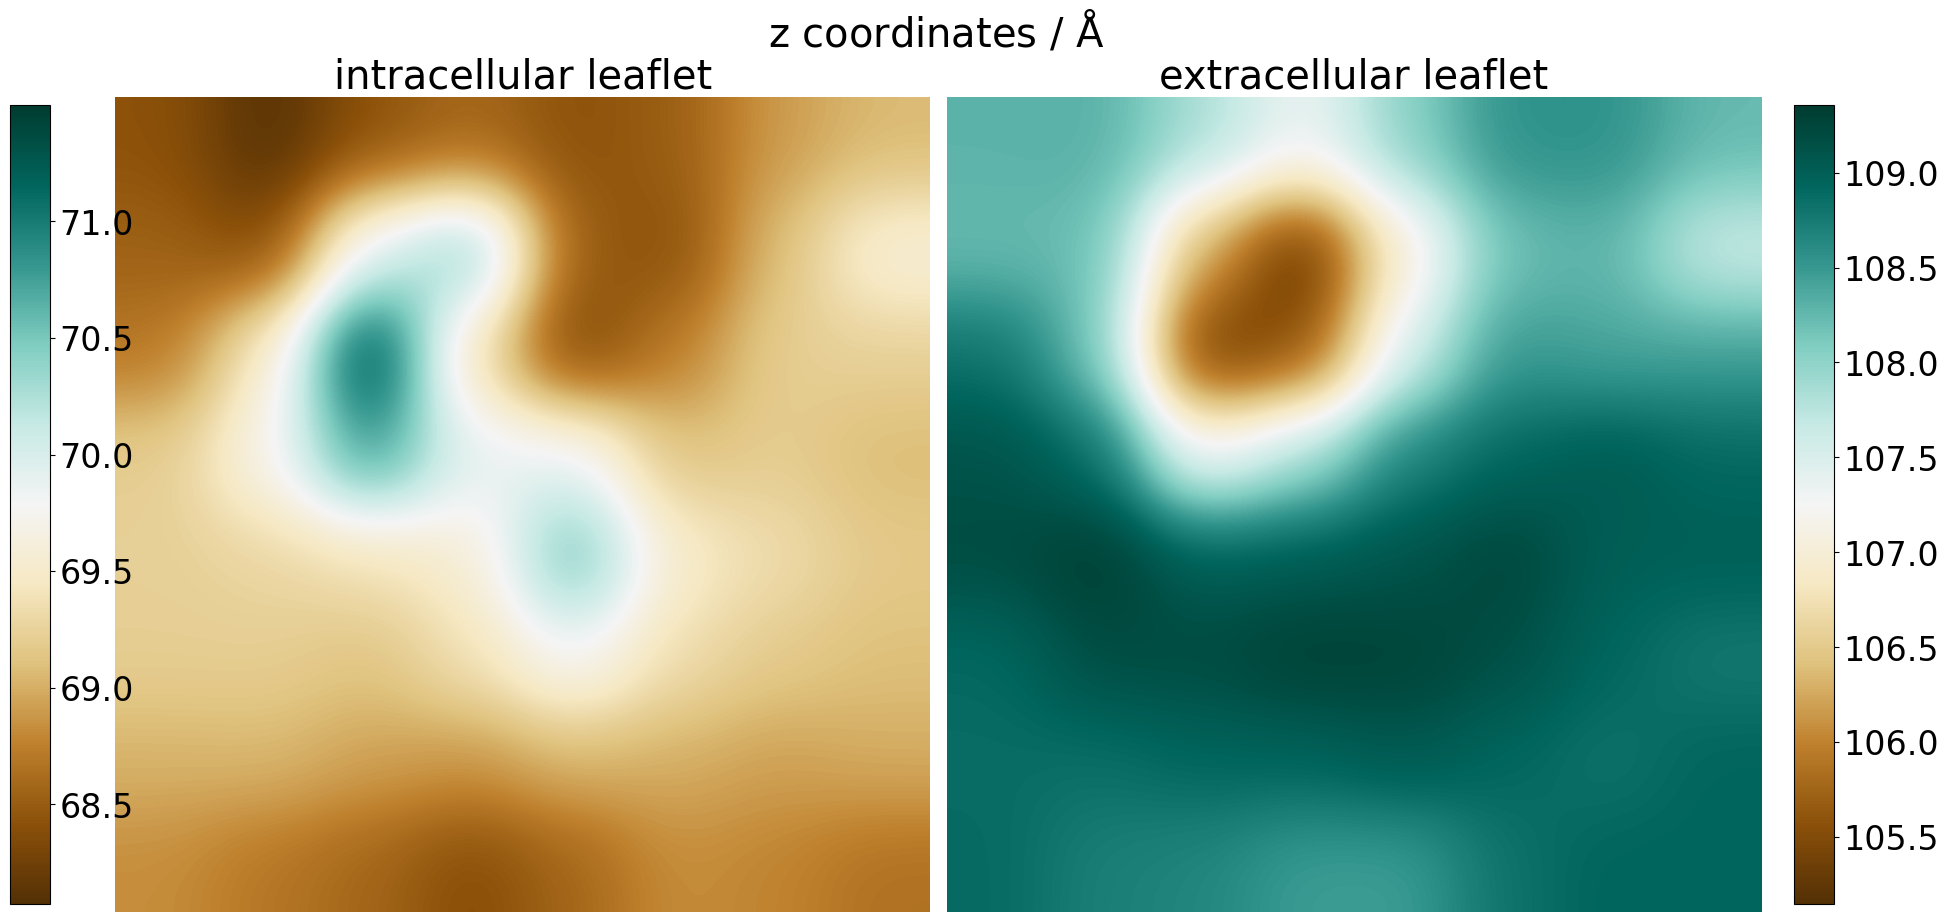

In [93]:
fig, ax = plt.subplots(ncols=2, constrained_layout=True) # watch out for the constrained layout arg, it changed in newer versions of matplotlib!
im0 = ax[0].imshow(surface_lower_leaflet.T, origin='lower', interpolation='gaussian', cmap='BrBG')
ax[0].axis('off')
ax[0].set_title('intracellular leaflet')
im1 = ax[1].imshow(surface_upper_leaflet.T, origin='lower', interpolation='gaussian', cmap='BrBG')
ax[1].axis('off')
ax[1].set_title('extracellular leaflet')
fig.colorbar(im0, fraction=0.049, pad=-2.36) # adjust padding to your liking
fig.colorbar(im1, fraction=0.049, pad=0.04)
fig.suptitle(r'z coordinates / $\mathrm{\AA}$', y=0.95) # adjust title yloc to your liking
#plt.savefig('z_coords_surf.png', dpi=200, bbox_inches='tight')
plt.show()

/tmp/ipykernel_1255945/1393355349.py:8: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im0, fraction=0.049, pad=-2.38)


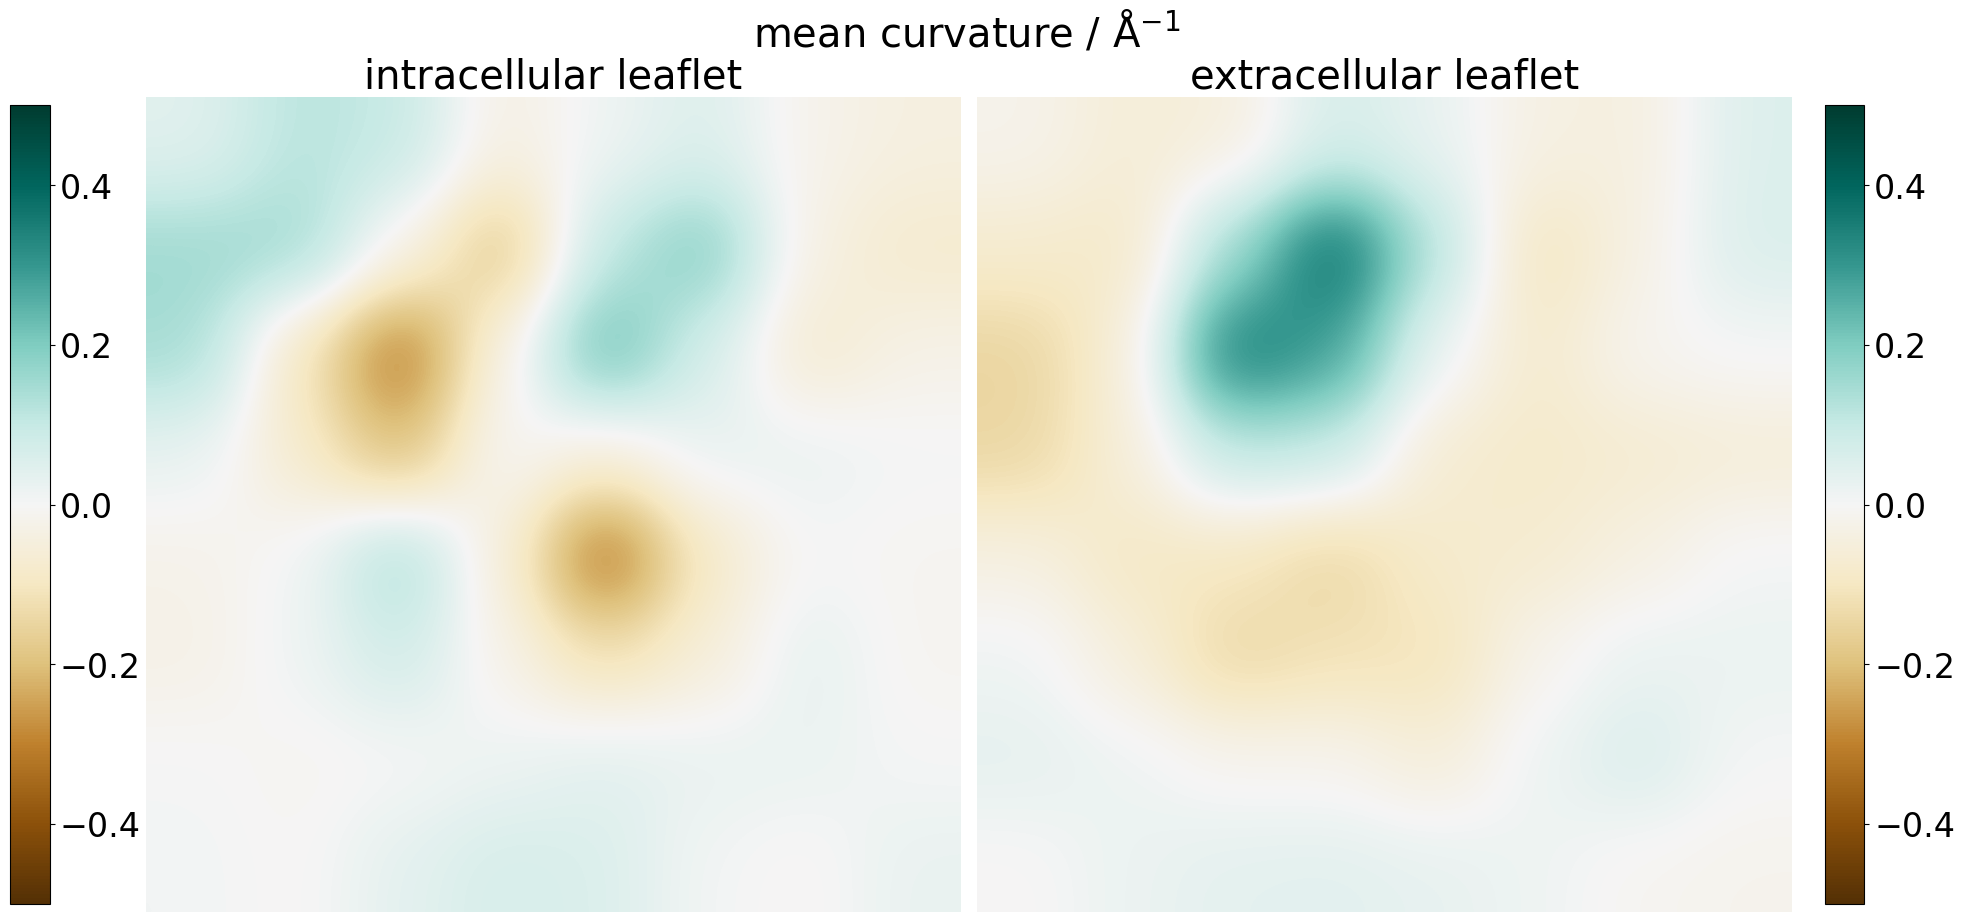

In [94]:
fig, ax = plt.subplots(ncols=2, constrained_layout=True)
im0 = ax[0].imshow(mean_lower_leaflet.T, origin='lower', interpolation='gaussian', cmap='BrBG', vmin=-0.5, vmax=0.5) # define a uniform scale using vmin and vmax
ax[0].axis('off')
ax[0].set_title('intracellular leaflet')
im1 = ax[1].imshow(mean_upper_leaflet.T, origin='lower', interpolation='gaussian', cmap='BrBG', vmin=-0.5, vmax=0.5)
ax[1].axis('off')
ax[1].set_title('extracellular leaflet')
fig.colorbar(im0, fraction=0.049, pad=-2.38)
fig.colorbar(im1, fraction=0.049, pad=0.04)
fig.suptitle(r'mean curvature / $\mathrm{\AA}^{-1}$', y=0.95)
#plt.savefig('mean_curvature_a3_8_8_trajectory.png', dpi=200, bbox_inches='tight')
plt.show()

/tmp/ipykernel_1255945/2778686857.py:8: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im0, fraction=0.044, pad=-2.37)


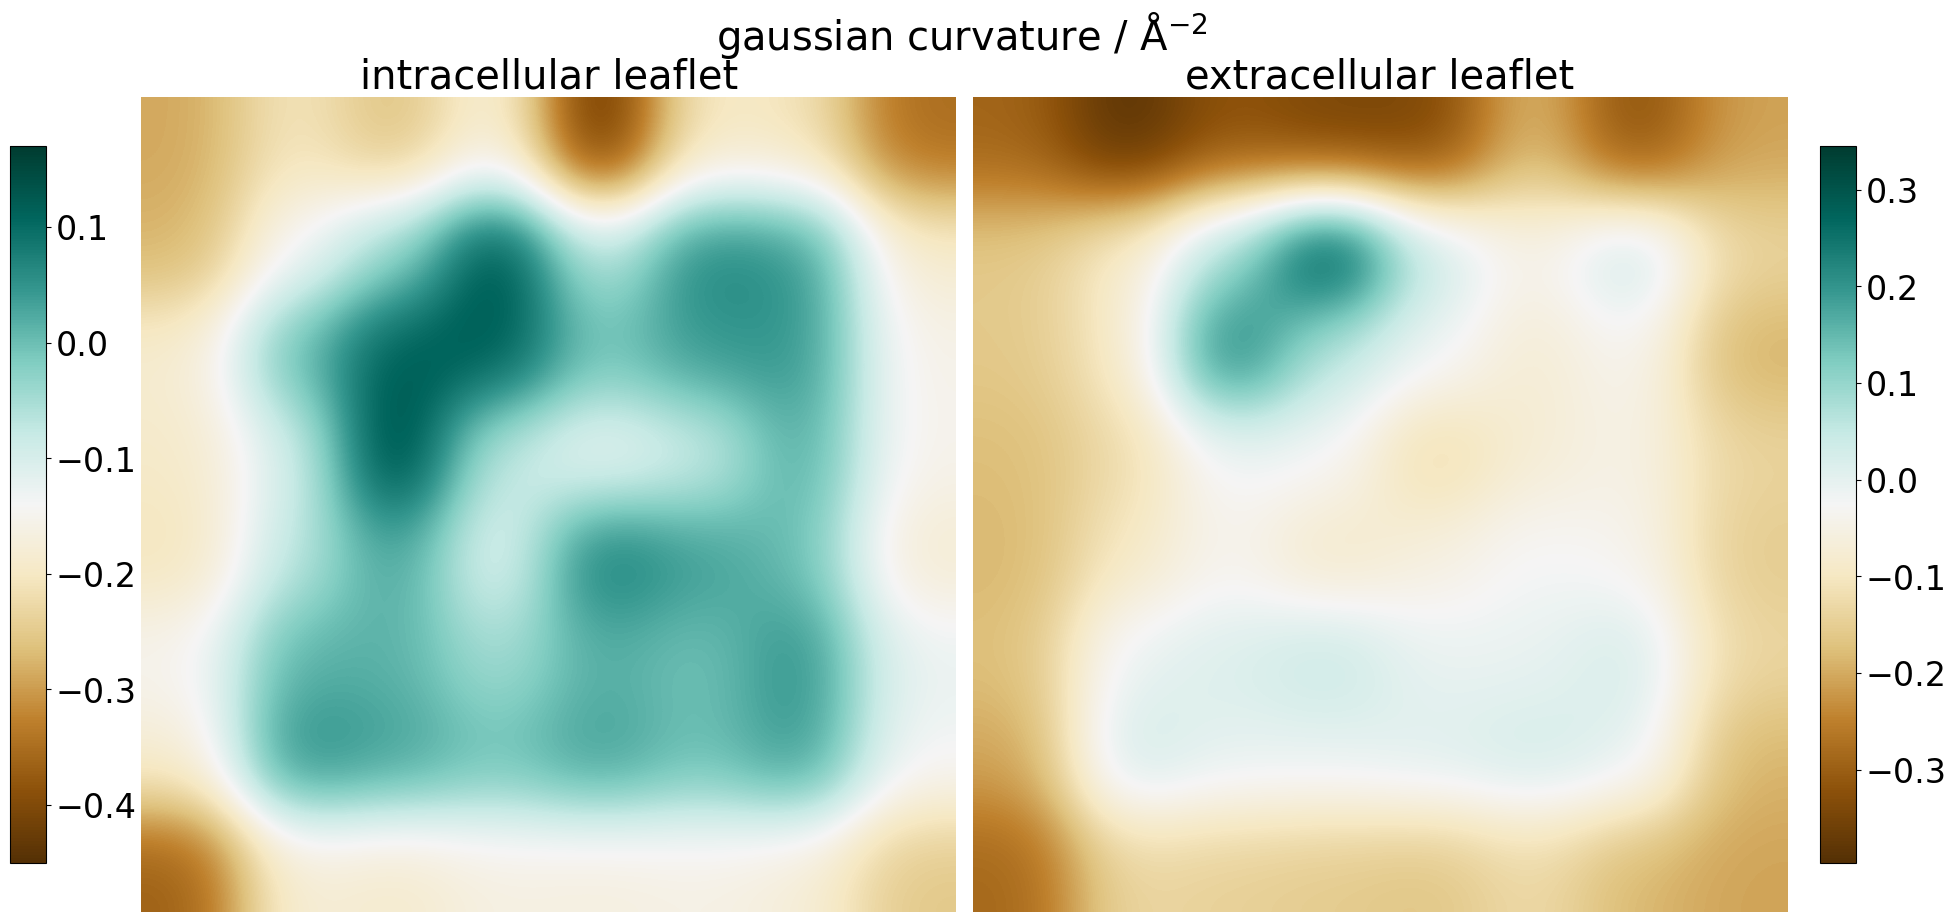

In [96]:
fig, ax = plt.subplots(ncols=2, constrained_layout=True)
im0 = ax[0].imshow(gaussian_lower_leaflet.T, origin='lower', interpolation='gaussian', cmap='BrBG')
ax[0].axis('off')
ax[0].set_title('intracellular leaflet')
im1 = ax[1].imshow(gaussian_upper_leaflet.T, origin='lower', interpolation='gaussian', cmap='BrBG')
ax[1].axis('off')
ax[1].set_title('extracellular leaflet')
fig.colorbar(im0, fraction=0.044, pad=-2.37)
fig.colorbar(im1, fraction=0.044, pad=0.04)
fig.suptitle(r'gaussian curvature / $\mathrm{\AA}^{-2}$', y=0.95)
#plt.savefig('gaussian_curvature.png', dpi=200, bbox_inches='tight')
plt.show()

haha where is the protein lol

In [99]:
globular_domain=u0.select_atoms('protein and (resid 1-84 or resid 195-236)')

In [100]:
hairpins=u0.select_atoms('protein and (resid 85-109 or resid 168-194)')

In [101]:
glob_cog=[]
hps_cog=[]
for ts in u0.trajectory:
    gcog=globular_domain.center_of_geometry()
    glob_cog.append(gcog)
    hcog=hairpins.center_of_geometry()
    hps_cog.append(hcog)

In [102]:
glob_cog=np.array(glob_cog)
hps_cog=np.array(hps_cog)

([<matplotlib.axis.YTick at 0x7f1909f199d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

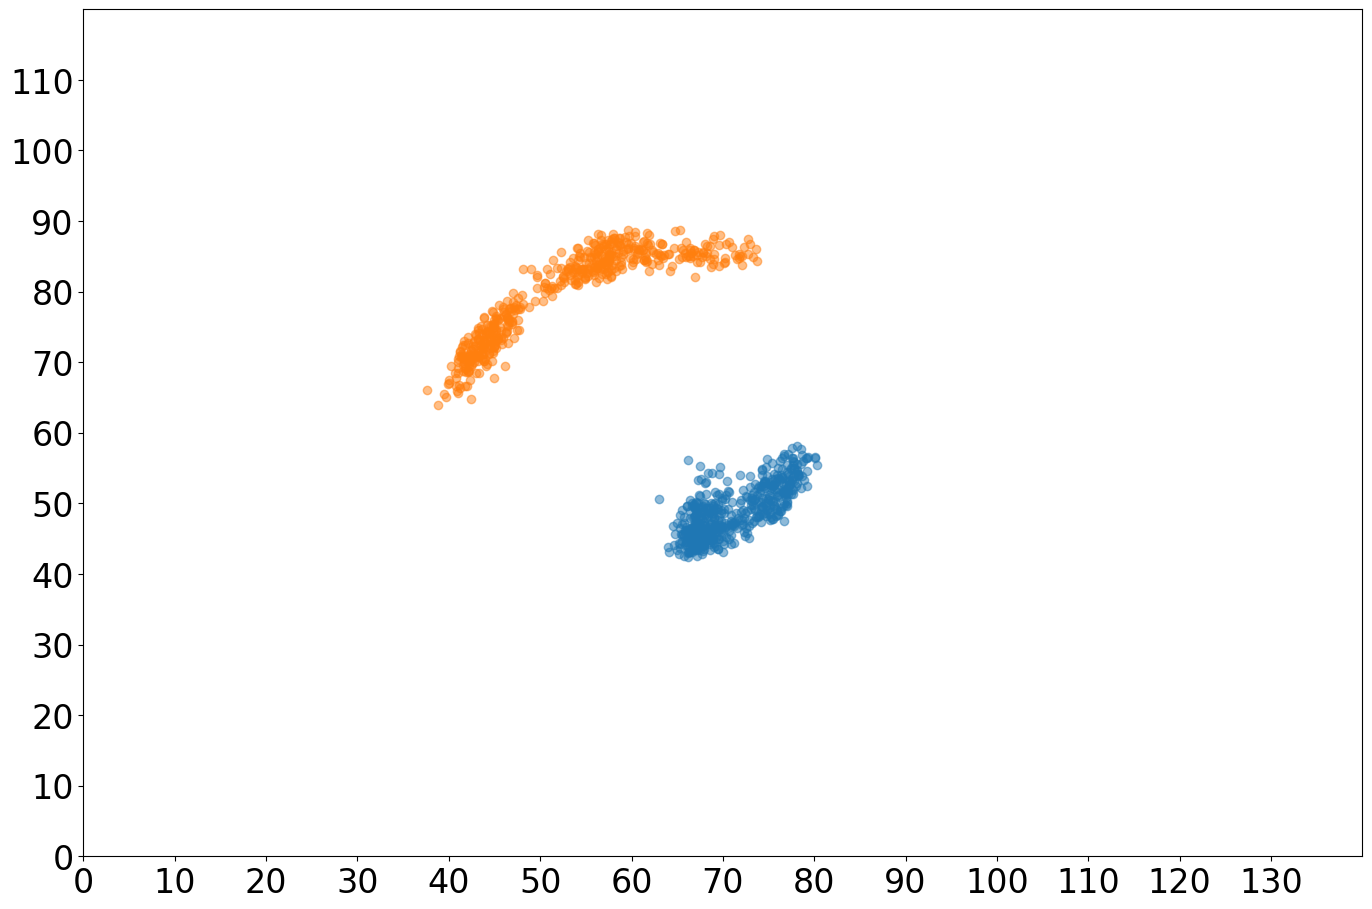

In [103]:
plt.scatter(glob_cog[:,0],glob_cog[:,1], alpha=0.5)
plt.scatter(hps_cog[:,0],hps_cog[:,1], alpha=0.5)
plt.xlim(0,140)
plt.ylim(0,120)
plt.xticks(np.arange(0,140,10))
plt.yticks(np.arange(0,120,10))
#plt.savefig('theres_the_prot.png', dpi=200)